# Exploring optimization over the VGG loss

In [1]:
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
import cv2 as cv2 # opencv computer vision library
from PIL import Image
import os
import sys

dirname = os.path.abspath(os.path.join(os.getcwd(), "..", "lib"))
sys.path.append(dirname)

from display import imshow
from vgg import VGGFeatures
from utils import preprocess, deprocess

## Importing the images

array([[<Axes: title={'center': 'Eye style'}>,
        <Axes: title={'center': 'Chair'}>]], dtype=object)

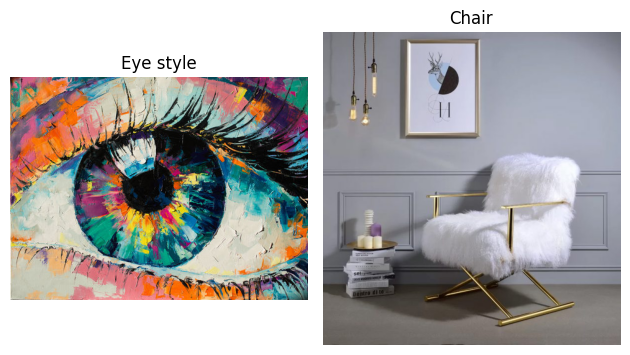

In [2]:
# Style
eye_style = Image.open("../data/style/eye.jpg")
# Objects or scenes
chair_image = Image.open("../data/scenes/chair.jpg")

imshow([eye_style, chair_image], ['Eye style', 'Chair'])

In [4]:
eye_style_prep = preprocess(eye_style)
chair_image_prep = preprocess(chair_image)

## Getting the features

In [3]:
vgg_model = VGGFeatures()

In [6]:
feature_style = vgg_model(eye_style_prep)
feature_chair_image = vgg_model(chair_image_prep)

In [9]:
loss = 0
criterion = nn.MSELoss()
for feature in feature_style.keys():
    loss = criterion(feature_style[feature],feature_chair_image[feature])
print("The loss is",loss.item())

The loss is 3.3359861373901367


## Brainstorming a model

According to the paper ([Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)), we will need three main block:
- Downsampling
- Residual Connections
- Upsampling

Downsampling is a custom Convolutional layer block, with a reflexion padding to prevent edge artifacts.

In [10]:
class CustomConvolutionalLayer(nn.Module):
    def init(self, in_size, out_size, kernel_size, stride=1):
        super(CustomConvolutionalLayer, self).__init__()
        ref_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(ref_padding)
        self.convolution2d = torch.nn.Conv2d(in_size, out_size, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.convolution2d(out)
        return out

The residual block is as defined in this paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). It basically prevents the vanishing gradient problem, and also allowing for the original sample to skip some connections. It is especially usefull in our case since we keep the original image shape more or less.

In [ ]:
class ResidualBlock(nn.Module):
    def init(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_layer1 = CustomConvolutionalLayer(channels, channels, kernel_size=3, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv_layer2 = CustomConvolutionalLayer(channels, channels, kernel_size=3, stride=1)
        self.batch_norm2 = nn.BatchNorm2d(channels, affine=True)

    def forward(self, x):
        out = self.relu(self.batch_norm1(self.conv_layer1(x)))
        out = self.batch_norm2(self.conv_layer2(out))
        out = out + x
        return out